In [6]:
import numpy as np
# from surfinpy import chemical_potential_plot
from surfinpy import utils as ut
from scipy.interpolate import CubicSpline
import yaml
import sys
colmap = ['#5B9BD5', '#4472C4', '#A5A5A5', '#772C24', '#ED7D31', '#FFC000', '#70AD47','#255E91', '#99ffcc']

In [7]:
def calculate_normalisation(phase, bulk, bulk_zpe, data_zpe):
    r"""Normalises the phase energy relative to the bulk material.
    Thus allowing the different phase calculations to be compared.
    TO DO rewrite 
    .. math::
        Energy = \frac{1}{2A} \Bigg( E_{MO}^{slab} -
        \frac{nCat_{slab}}{nCat_{Bulk}} E_{MO}^{Bulk} \Bigg)

    where Energy is the slab energy normalised to the
    bulk, :math:`E_{MO}^{slab}` is the DFT slab energy, :math:`nCat_{slab}`
     is the number of slab cations, :math:`nCat_{Bulk}` is the number of bulk
    cations, :math:`E_{MO}^{Bulk}` is the DFT bulk energy A is the surface
    area.

    TO DO Rewrite

    Parameters
    ----------
    slab_energy : float
        Energy of the slab from DFT
    slab_cations : int
        Total number of cations in the slab
    bulk : dictionary
        Dictionary of bulk properties
    area : float
        Surface area

    Returns
    -------
    float:
        Constant normalising the slab energy to the bulk energy.
    """
    try:
        Phase_units = phase['F-Units']
    except KeyError:
        Phase_units = 0

    # Calculating Energy of reaction  =  Ephase - EMgO
    return ((phase['Energy']+ (data_zpe * Phase_units)) - (phase['Cation'] / bulk['Cation']) * ((bulk['Energy'] /
            bulk['F-Units'])+ bulk_zpe))


In [8]:
def calculate_surface_energy(deltamux, ynew, 
                                      x_energy,
                                      z_energy, deltamuz,
                                      phase,
                                      bulk,
                                      normalised_bulk,
                                     exp_xnew, exp_znew, new_bulk_svib, new_data_svib): 
    
    try:
        Phase_units = phase['F-Units']
    except KeyError:
        Phase_units = 0
    
    return (
        normalised_bulk - deltamux * phase['X'] - deltamuz * phase['Z'] - (
        (x_energy + exp_xnew) * phase['X']) - ((z_energy + exp_znew) * phase['Z'])-
        (new_data_svib * Phase_units - ((phase['Cation'] / (bulk['Cation'])*new_bulk_svib))))

In [9]:
def evaluate_phases(data, bulk, x, y,
                             nphases, x_energy, z_energy, mu_z, exp_x, exp_z, Entropy_true, ZPE_true):
#     data, bulk, x, y, nphases, x_energy, y_energy, z):
    """Calculates the surface energies of each phase as a function of chemical
    potential of x and y. Then uses this data to evaluate which phase is most
    stable at that x/y chemical potential cross section.

    Parameters
    ----------
    data : list
        List containing the dictionaries for each phase
    bulk : dictionary
        dictionary containing data for bulk
    x : dictionary
        X axis chemical potential values
    y : dictionary
        Y axis chemical potential values
    nsurfaces : int
        Number of phases
    x_energy : float
        DFT 0K energy for species x
    y_energy : float
        DFT 0K energy for species y

    Returns
    -------
    phase_data  : array like
        array of ints, with each int corresponding to a phase.
    """
    xnew = ut.build_xgrid(x, y)
    ynew = ut.build_ygrid(x, y)
    znew = (xnew * 0 ) + mu_z
    exp_xnew = build_zgrid(exp_x, x)
    exp_znew = build_zgrid(exp_z, x)
    
    bulk_zpe=0
    data_zpe=0
    new_data_svib = 0
    new_bulk_svib = 0
 
    
    S = np.array([])
    
    if Entropy_true==True or ZPE_true==True:
        bulk_zpe, bulk_svib = Vib_Calc(bulk['File-Name'], y, ZPE_true, Entropy_true)
        new_bulk_svib = build_entgrid(bulk_svib, x, ynew)
        
    for k in range(0, nphases):
        if Entropy_true==True or ZPE_true==True:
            data_zpe, data_svib = Vib_Calc(data[k]['File-Name'], y, ZPE_true, Entropy_true)
            new_data_svib = build_entgrid(bulk_svib, x, ynew)            

        normalised_bulk = calculate_normalisation(data[k],
                                                  bulk, bulk_zpe, data_zpe
                                                   )

        SE = calculate_surface_energy(xnew, ynew, 
                                      x_energy,
                                      z_energy, znew,
                                      data[k],
                                      bulk,
                                      normalised_bulk,
                                     exp_xnew, exp_znew, new_bulk_svib, new_data_svib)

        S = np.append(S, SE)
    


    phase_data, SE = ut.get_phase_data(S, nphases)
    return phase_data, SE

In [10]:
def build_entgrid(z, y, ynew):
    znews = np.tile(z, len(y))
    znews = np.reshape(znews, (len(z), len(y)), order='F')
    temp_ent = np.multiply(znews, ynew)
    
    return temp_ent


In [11]:
def build_zgrid(z, y):
    """Builds a 2D grip of values for the x axis.

    Parameters
    ----------
    x : array like
        numpy array
    y : array like
        numpy array

    Returns
    -------
    xnew : array like
        numpy array
    """
    znews = np.tile(z, y.size)
    znews = np.reshape(znews, (z.size, y.size), order='F')

    return znews


In [12]:
def temperature_correction(nist_file, deltaY):
    """Use experimental data to correct the DFT free energy of an adsorbing
    species to a specific temperature.

    Parameters
    ----------
    nist_file : array like
        numpy array containing experiemntal data from NIST_JANAF
    temperature : int
        Temperature to correct to

    Returns
    -------
    gibbs : float
        correct free energy
    """
    Y = np.arange(deltaY['Range'][0], deltaY['Range'][1],
                  1, dtype="int")
    Y = Y -1
    nist_data = ut.read_nist(nist_file)
    
    h0 = nist_data[0, 4]
    fitted_s = fit(nist_data[:, 0], nist_data[:, 2], np.arange(1, 3000))
    fitted_h = fit(nist_data[:, 0], nist_data[:, 4], np.arange(1, 3000))

    fitted_h = fitted_h - fitted_h[0]
    
    gibbs = calculate_gibbs(np.arange(1, 3000), fitted_s, fitted_h)

    return gibbs[Y]

In [13]:
def fit(x, y, t):
    '''Fit a polynominal function to thermochemical data from NIST_JANAF

    Parameters
    ----------
    x : array like
        x axis for fit
    y : array like
        y axis for fit
    t : array like
        x axis to be fitted

    Returns
    -------
    shift : array like
        data fitted from x and y to t
    '''
#     z = np.polyfit(x, y, 3)
#     f = np.poly1d(z)
    
    cs = CubicSpline(x, y, bc_type='clamped')

    shift = cs(t)
    

    
#     shift = f(t)

    return shift


In [14]:

def calculate_gibbs(t, s, h):
    '''Calculate the gibbs free energy from thermochemcial data
    obtained from the NIST_JANAF database

    Parameters
    ----------
    t : array like
        Temperature range
    s : array like
        delta s values from nist
    h : array like
        selta h values from nist

    Returns
    -------
    g : array like
        gibbs energy as a function of temperature
    '''
    deltas = (s * 0.01036) / 1000
    deltah = h  * 0.01036
    g = deltah - t * deltas
#     g = 0- t * deltas

    return g


In [108]:
def calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z, Entropy_true=False, ZPE_true=False,
              output="Phase_Diagram.png"):

    data = sorted(data, key=lambda k: (k['Z']))
    nphases = len(data)

    X = np.arange(deltaX['Range'][0], deltaX['Range'][1],
                  0.025, dtype="float")
    Y = np.arange(deltaY['Range'][0], deltaY['Range'][1],
                  1, dtype="float")

    phases, SE = evaluate_phases(data, bulk, X, Y,
                             nphases, x_energy, z_energy, mu_z, exp_x, exp_z, Entropy_true, ZPE_true)
    ticks = np.unique([phases])
    c = []
    for k in range(0,ticks.size):
        c.append(colmap[ticks[k]-1])

#     phases = ut.transform_numbers(phases, ticks)

    Z = np.reshape(phases, (Y.size, X.size))
    
#     labels = ut.get_labels(ticks, data)
    labels = []
    for i in range(0, ticks.size):
        val = ticks[i] - 1
        val = int(val)
        label = data[val]['Label']
        labels.append(label)

    system = ChemicalPotentialPlot(X,Y,Z,labels,
                                   ticks,deltaX['Label'],deltaY['Label'], c)

#     print(type(phases))

    import pandas
    df = pandas.DataFrame(Z, columns=X, index=Y)
    df.to_csv('file.csv')

#     system = PVTPlot.pvt_plot(X, Y, Z)
    return system, c

#  Vibrational Properties Utils

In [16]:
def read_vibdata(vib_file):
#Read Data 
    with open(vib_file, 'r') as file:
        vib_prop = yaml.load(file)
    return vib_prop

In [17]:
def build_tempgrid(z, y):
    """Builds a 2D grip of values for the x axis.

    Parameters
    ----------
    x : array like
        numpy array
    y : array like
        numpy array

    Returns
    -------
    xnew : array like
        numpy array
    """
    znews = np.tile(z, len(y))

    znews = np.reshape(znews, (len(z), len(y)), order='F')
    

    return znews

In [18]:
def build_freqgrid(z, y):
    """Builds a 2D grip of values for the x axis.

    Parameters
    ----------
    x : array like
        numpy array
    y : array like
        numpy array

    Returns
    -------
    xnew : array like
        numpy array
    """
    znews = np.tile(z, (len(y),1))

    return znews

In [19]:
def ZPE_Calc(vib_prop):
# Zero Point Energy Calc

# hc = h * c * 0.5 unit cmJ
# 1.6021E-19 j to eV conversion

    hc = 9.93247898996E-24

    vib_prop_1 = list(map(lambda x : x * hc, vib_prop['Frequencies']))
    zpe = sum(vib_prop_1)
    zpe = zpe / 1.6021E-19 / vib_prop['F-Units']

    
    return zpe


In [20]:
def Entropy_Calc(freq, temp, vib_prop):
# Entropy Calc
    hc = 1.99E-25 *100.0E0
    k = 1.38064852E-23
    R=8.314
    np.seterr(over='ignore')


    Theta = np.multiply(freq,hc)
    Theta = np.divide(Theta, k)

    u = np.multiply(Theta, R)/(np.exp(np.divide(Theta, temp), dtype=np.float64)-1)
    uvib = np.sum(u, axis=1)
    uvib = uvib/vib_prop['F-Units'] 

    a = np.multiply(Theta, R)*np.log(1-np.exp(np.negative(np.divide(Theta, temp)), dtype=np.float64))
    avib = np.sum(a, axis=1)
    avid = avib/vib_prop['F-Units'] 

    s = np.divide(np.subtract(u,a), temp)
    svib = np.sum(s, axis=1, dtype=np.float64)
    svib = svib/vib_prop['F-Units'] 
    svib = np.divide(svib,96485)
    
    return svib

In [21]:
def Vib_Calc(vib_file, temp_r, zpe_true, ent_true):
#     temp_r = np.arange(temp_range['Range'][0], temp_range['Range'][1],
#                       1, dtype="int")
    
    vib_prop = read_vibdata(vib_file)
    
    new_temp = build_tempgrid(temp_r, vib_prop['Frequencies']) 
    freq = build_freqgrid(vib_prop['Frequencies'], temp_r) 
    

    
    zpe = 0
    if zpe_true==True:
        zpe = ZPE_Calc(vib_prop)
    if ent_true==True:
        svib = Entropy_Calc(freq, new_temp, vib_prop)
    
   
    return(zpe, svib)

# Plot

In [29]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from surfinpy import utils as ut

class ChemicalPotentialPlot:
    """Class that plots a phase diagram as a function of chemical potential.

    Parameters
    ----------
    x : array like
        x axis, chemical potential of species x
    y : array like
        y axis, chemical potential of species y
    z : array like
        two dimensional grid, phase info
    labels : list
        list of phase labels
    ticks : list
        list of phases
    xlabel : str
        species name for x axis label
    ylabel : str
        species name for y axis label
    """
    def __init__(self, x, y, z, labels, ticks, xlabel, ylabel,c):
        self.x = x
        self.y = y
        self.z = z
        self.labels = labels
        self.ticks = ticks
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.c = c

    def plot_phase(self, temperature=None, xlabel=None, ylabel=None, output="phase.png", 
                   colourmap="viridis", set_style="default", figsize=None, show_fig=True):
        """Plots a simple phase diagram as a function of chemical potential.

        Parameters
        ----------
        temperature: int (optional)
            Temperature. Default=None
        xlabel: str (optional)
            Set a custom x-axis label. Default=None
        ylabel: str (optional)
            Set a custom y-axis label. Default=None
        output: str (optional)
            Output filename. Default='phase.png'
            If output is set to `None`, no output is generated.
        colourmap: str (optional)
            Colourmap for the plot. Default='viridis'
        figsize: tuple (optional)
            Set a custom figure size. Default=None
        show_fig: bool (optional)
            Automatically display a figure. Default=True
            If set to False the plot is returned as an object.
        """
        if set_style:
            plt.style.use(set_style)
        levels = ut.get_levels(self.z)
        ticky = np.subtract(levels,0.5)
        temperature_label = str(temperature) + " K"
        if xlabel:
            XLab = xlabel
        else:
            XLab = "$\Delta \mu_{\mathrm{" + self.xlabel + "}}$" + " (eV)"
        if ylabel:
            YLab = ylabel
        else:
            YLab = "$\Delta \mu_{\mathrm{" + self.ylabel + "}}$" + " (K)"
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        CM = ax.contourf(self.x, self.y, self.z, levels=levels, colors=c)
        ax.set_ylabel(YLab, fontsize=14)
        ax.set_xlabel(XLab, fontsize=14)
        if temperature:
            ax.text(0.1, 0.95, temperature_label,  fontsize=15, color="white",
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes)
        ax.tick_params(labelsize=12)
        cbar = fig.colorbar(CM, ticks=ticky, pad=0.1)
        cbar.ax.set_yticklabels(self.labels)
        plt.tight_layout()
        if output:
            plt.savefig(output, dpi=600)
        if show_fig:
            plt.show()
        else:
            return ax

    def plot_mu_p(self, temperature=298, output="phase.png", colourmap="viridis",
                  set_style="default"):
        """ Plots a phase diagram  with two sets of axis, one as a function of
        chemical potential and the second is as a function of pressure.

        Parameters
        ----------
        temperature : int (optional)
            temperature
        output : str (optional)
            output filename
        colourmap : str
            colourmap for the plot
        """

        if set_style:
            plt.style.use(set_style)
        p1 = ut.pressure(self.x, temperature)
#         p2 = ut.pressure(self.y, temperature)
        temperature_label = str(temperature) + " K"
        levels = [0, *self.ticks]
#         levels = ut.get_levels(self.z)
        ticky = np.subtract(levels,0.5)
        X1Lab = "$\Delta \mu_{\mathrm{" + self.xlabel + "}}$" + " (eV)"
        Y1Lab = self.ylabel +  " (K)"
        X2Lab = "$P_" + "{\mathrm{" + self.xlabel + "}}$" + " " + str(temperature) + " K (bar)"
#         Y2Lab = self.ylabel + "K"
        fig = plt.figure(dpi=96, facecolor='#eeeeee', tight_layout=1,figsize=(6,4.5))
        ax = fig.add_subplot(121)
        gs = gridspec.GridSpec(1, 2, width_ratios=[.95, .05])
        ax, axR = plt.subplot(gs[0]), plt.subplot(gs[1])
        CM = ax.contourf(self.x, self.y, self.z, levels=levels, colors=c)
        ax.set_xlabel(X1Lab, fontsize=14)
        ax.set_ylabel(Y1Lab, fontsize=14)
#         ax2 = ax.twinx()
#         ax2.set_ylim(p2[0], p2[-1])
#         ax2.set_ylabel(Y2Lab, fontsize=13)
        ax2 = ax.twiny()
        ax2.set_xlim(p1[0], p1[-1])
        ax2.set_xlabel(X2Lab, fontsize=12)
        ax.tick_params(labelsize=10)
#         ax2.tick_params(labelsize=10)
        ax2.tick_params(labelsize=10)
        cbar = fig.colorbar(CM, extend='both', cax=axR, ticks=ticky)
        cbar.ax.set_yticklabels(self.labels)
#         axR.set_xlabel('$H_2O$ $nm^{-2}$', fontsize=12)


#         expx = [-0.25, -0.12, 0, 0, 0.4]
#         expy = [298,298,282,327, 290]
#         ax4 = plt.subplot(gs[0])
#         sp = plt.scatter(expx, expy)
#         ax4.set_xlim(-1,0.6)


        plt.savefig(output, dpi=600)
        plt.show()


# WorkBook Example

Example of Code that will be in the workbook example.



In [63]:
bulk = {'Cation' : 1, 'Anion' : 1, 'Energy' : -92.35637426, 'F-Units' : 10}

In [64]:
MgO =     {'Cation': 10, 'X': 0, 'Z': 0, 'Energy': -92.35637426,   'Label': 'Periclase'}
Art =      {'Cation': 10, 'X': 5, 'Z': 20, 'Energy': -467.308589,   'Label': 'Artinite'}
Bru =    {'Cation': 10, 'X': 0, 'Z': 10, 'Energy': -227.3449021,   'Label': 'Brucite'}
Nes =    {'Cation': 10, 'X': 10, 'Z': 30, 'Energy': -705.7643942,   'Label': 'Nesquehonite'}
Mag =       {'Cation': 10, 'X': 10, 'Z': 0, 'Energy': -310.3283693,   'Label': 'Magnesite'}
Lan =   {'Cation': 10, 'X': 10, 'Z': 50, 'Energy': -971.8116011,  'Label': 'Lansfordite'}
Hyd = {'Cation': 10, 'X': 8, 'Z': 10, 'Energy': -398.6071433,  'Label': 'Hydromagnesite'}

In [65]:
data = [MgO, Art, Bru, Nes, Mag, Lan, Hyd]

In [66]:
deltaX = {'Range': [ -1, 1],  'Label': 'CO_2'}
deltaY = {'Range': [ 263, 373], 'Label': 'Temperature'}
x_energy=-20.53412969
z_energy=-12.83725889
mu_z = 0

In [67]:
exp_x = temperature_correction("CO2.txt", deltaY)
exp_z = temperature_correction("H2O.txt", deltaY)

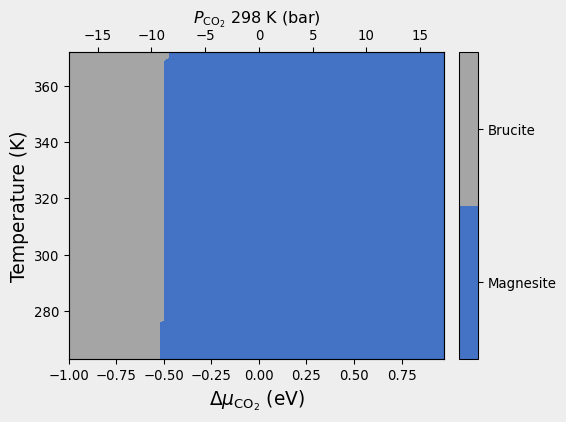

In [68]:
system, c = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z)
system.plot_mu_p(set_style="seaborn-dark-palette", colourmap="RdYlBu")

In [24]:
# data = [MgO, Art, Bru, Nes, Lan, Hyd]
Mag =       {'Cation': 10, 'X': 10, 'Z': 0, 'Energy': 100310.3283693,   'Label': 'Magnesite'}
data = [MgO, Art, Bru, Nes, Mag, Lan, Hyd]

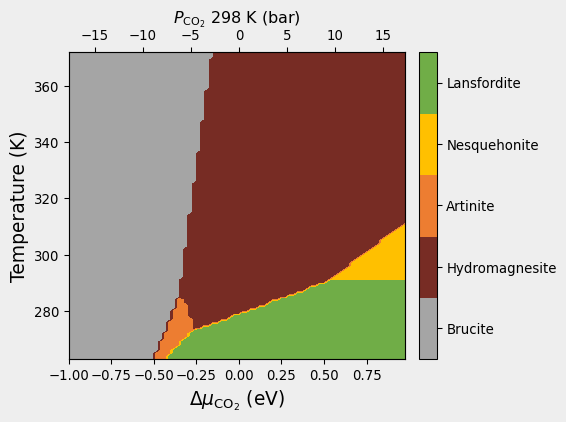

In [61]:
system, c = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z)
system.plot_mu_p(set_style="seaborn-dark-palette", colourmap="RdYlBu")

# Solid Entropy

In [26]:
bulk = {'Cation' : 1, 'Anion' : 1, 'Energy' : -92.35637426, 'F-Units' : 10, 'File-Name': 'bulk_vib.yaml'}

In [27]:
MgO = {'Cation': 10, 'X': 0, 'Z': 0, 'Energy': -92.35637426,   'Label': 'Periclase', 'File-Name': 'MgO_vib.yaml', 'F-Units': 10}
Art = {'Cation': 10, 'X': 5, 'Z': 20, 'Energy': -467.308589,   'Label': 'Artinite', 'File-Name': 'Art_vib.yaml', 'F-Units': 5}
Bru = {'Cation': 10, 'X': 0, 'Z': 10, 'Energy': -227.3449021,   'Label': 'Brucite', 'File-Name': 'Bru_vib.yaml', 'F-Units': 10}
Nes = {'Cation': 10, 'X': 10, 'Z': 30, 'Energy': -705.7643942,   'Label': 'Nesquehonite', 'File-Name': 'Nes_vib.yaml', 'F-Units': 10}
Mag = {'Cation': 10, 'X': 10, 'Z': 0, 'Energy': -310.3283693,   'Label': 'Magnesite', 'File-Name': 'Mag_vib.yaml', 'F-Units': 10}
Lan = {'Cation': 10, 'X': 10, 'Z': 50, 'Energy': -971.8116011,  'Label': 'Lansfordite', 'File-Name': 'Lan_vib.yaml', 'F-Units': 10}
Hyd = {'Cation': 10, 'X': 8, 'Z': 10, 'Energy': -398.6071433,  'Label': 'Hydromagnesite', 'File-Name': 'Hyd_vib.yaml', 'F-Units': 2}

In [28]:
data = [MgO, Art, Bru, Nes, Mag, Lan, Hyd]

In [29]:
deltaX = {'Range': [ -1, 0.6],  'Label': 'CO_2'}
deltaY = {'Range': [ 273, 373], 'Label': 'Temperature'}
x_energy=-20.53412969
z_energy=-12.83725889
mu_z = 0

Entropy_true = True
ZPE_true = False


In [30]:
exp_x = temperature_correction("CO2.txt", deltaY)
exp_z = temperature_correction("H2O.txt", deltaY)

<ipython-input-11-e2a4dded0743>:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  vib_prop = yaml.load(file)


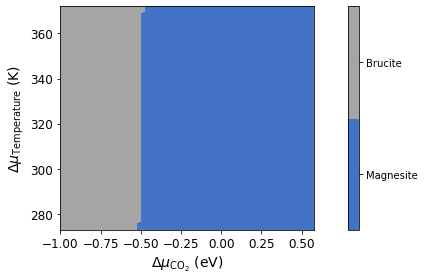

In [32]:
system, c = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z, Entropy_true, ZPE_true)
system.plot_phase(set_style="seaborn-dark-palette", colourmap="RdYlBu")

In [33]:
data = [MgO, Art, Bru, Nes, Lan, Hyd]

<ipython-input-11-e2a4dded0743>:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  vib_prop = yaml.load(file)


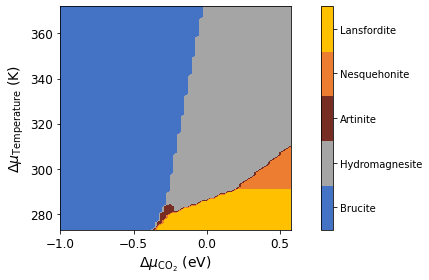

In [35]:
system, c = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z, Entropy_true, ZPE_true)
system.plot_phase(set_style="seaborn-dark-palette", colourmap="RdYlBu")

In [ ]:
system = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z, Entropy_true, ZPE_true)
system.plot_mu_p(set_style="seaborn-dark-palette", colourmap="RdYlBu")

# POx Phase Diagram

In [ ]:
bulk = {'Cation' : 1, 'Anion' : 0, 'Energy' : -1015.70, 'F-Units' : 27}

In [ ]:
PO4 =     {'Cation': 27, 'Z': 0.25, 'X': -2.25, 'Energy': -993.11,   'Label': 'PO_4'}
PO5 =      {'Cation': 27, 'Z': 0.25, 'X': -1.75, 'Energy': -1002.5226,   'Label': 'PO_5'}
PO6 =    {'Cation': 27, 'Z': 0.25, 'X': -1.25, 'Energy': -1010.5135,   'Label': 'PO_6'}


In [ ]:
data = [PO4, PO5, PO6]

In [ ]:
deltaX = {'Range': [ -10, 5], 'Label': 'O2'}
deltaY = {'Range': [ 1, 1000], 'Label': 'Temperature'}

mu_z = 0
z_energy=-49.18
x_energy=-9.88

In [ ]:
exp_x = temperature_correction("O2.txt", deltaY)
exp_z = temperature_correction("P2O5.txt", deltaY)


In [ ]:
system = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z)
system.plot_phase(set_style="seaborn-dark-palette", colourmap="RdBu")

# UO2 Phase Diagram

In [75]:
bulk = {'Cation' : 1, 'Anion' : 0, 'Energy' : -938.76867296, 'F-Units' : 32}

In [76]:
U32O64H0 =     {'Cation': 32, 'X': 0, 'Z': 0, 'Energy': -938.76867296,   'Label': 'U32O64H0'}
U32O64H1 =     {'Cation': 32, 'X': 0, 'Z': 0.5, 'Energy': -941.9498006,   'Label': 'U32O64H1'}
U32O64H2 =      {'Cation': 32, 'X': 0, 'Z': 1, 'Energy': -946.0943744,   'Label': 'U32O64H2'}
U32O63H0 =    {'Cation': 32, 'X': -0.5, 'Z': 0, 'Energy': -928.0471514,   'Label': 'U32O63H0'}
U32O63H1 =     {'Cation': 32, 'X': -0.5, 'Z': 0.5, 'Energy': -934.3267507,   'Label': 'U32O63H1'}
U32O63H2 =      {'Cation': 32, 'X': -0.5, 'Z': 1, 'Energy': -936.266416,   'Label': 'U32O63H2'}
U32O65H0 =    {'Cation': 32, 'X': 0.5, 'Z': 0, 'Energy': -944.9309093,   'Label': 'U32O65H0'}
U32O65H1 =     {'Cation': 32, 'X': 0.5, 'Z': 0.5, 'Energy': -949.0715217,   'Label': 'U32O65H1'}
U32O65H2 =      {'Cation': 32, 'X': 0.5, 'Z': 1, 'Energy': -952.1361994,   'Label': 'U32O65H2'}

In [77]:
data = [U32O64H0, U32O64H1, U32O64H2, U32O63H0, U32O63H1,  U32O63H2, U32O65H0, U32O65H1, U32O65H2]

P O$_2$ vs T at P H$_2$ = 0 All Phases

In [78]:
deltaX = {'Range': [ -10, 5],  'Label': 'O_2'}
deltaY = {'Range': [ 1, 3000], 'Label': 'Temperature'}

x_energy=-9.883704
mu_z = 0
z_energy=-6.771542

In [79]:
exp_x = temperature_correction("O2.txt", deltaY)
exp_z = temperature_correction("H2.txt", deltaY)

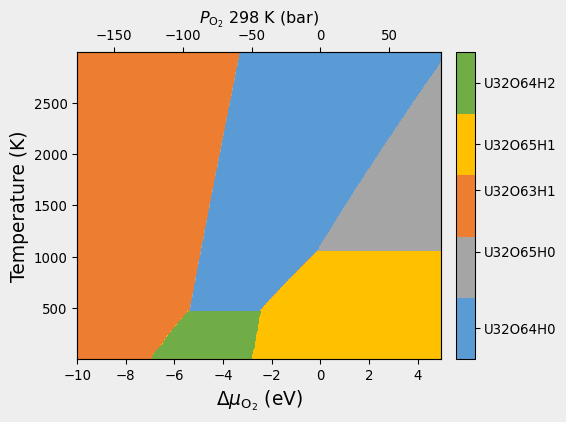

In [80]:
system,c = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z)
system.plot_mu_p(set_style="seaborn-dark-palette", colourmap="RdBu", output="H2_0_All_mvt")

P O$_2$ vs T at P H$_2$ = -1 All Phases

In [81]:
deltaX = {'Range': [ -10, 5],  'Label': 'O_2'}
deltaY = {'Range': [ 1, 3000], 'Label': 'Temperature'}

x_energy=-9.883704
mu_z = -1
z_energy=-6.771542

In [82]:
exp_x = temperature_correction("O2.txt", deltaY)
exp_z = temperature_correction("H2.txt", deltaY)

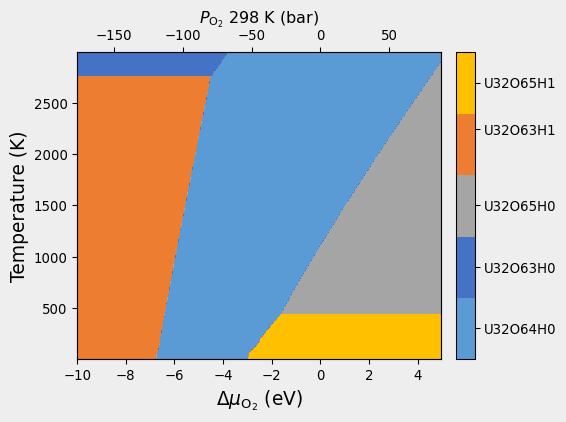

In [83]:
system,c = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z)
system.plot_mu_p(set_style="seaborn-dark-palette", colourmap="RdBu", output="H2_-1_All_mvt")

P O$_2$ vs T at P H$_2$ = 0 No Bulk

In [84]:
U32O64H0 =     {'Cation': 32, 'X': 0, 'Z': 0, 'Energy': 1000000,   'Label': 'U32O64H0'}
data = [U32O64H0, U32O64H1, U32O64H2, U32O63H0, U32O63H1,  U32O63H2, U32O65H0, U32O65H1, U32O65H2]

In [85]:
deltaX = {'Range': [ -10, 5],  'Label': 'O_2'}
deltaY = {'Range': [ 1, 3000], 'Label': 'Temperature'}

x_energy=-9.883704
mu_z = 0
z_energy=-6.771542

In [86]:
exp_x = temperature_correction("O2.txt", deltaY)
exp_z = temperature_correction("H2.txt", deltaY)

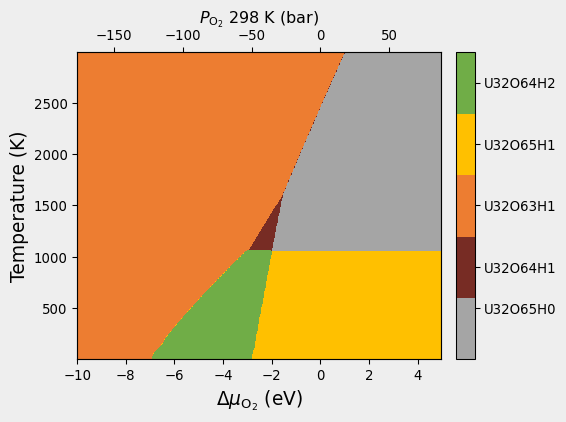

In [87]:
system,c = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z)
system.plot_mu_p(set_style="seaborn-dark-palette", colourmap="RdBu", output="H2_0_NoBulk_mvt")

P O$_2$ vs T at P H$_2$ = -1 No Bulk

In [88]:
deltaX = {'Range': [ -10, 5],  'Label': 'O_2'}
deltaY = {'Range': [ 1, 3000], 'Label': 'Temperature'}

x_energy=-9.883704
mu_z = -1
z_energy=-6.771542

In [89]:
exp_x = temperature_correction("O2.txt", deltaY)
exp_z = temperature_correction("H2.txt", deltaY)

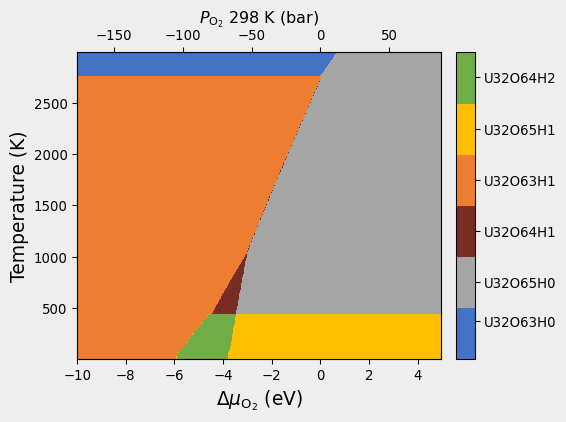

In [90]:
system,c = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z)
system.plot_mu_p(set_style="seaborn-dark-palette", colourmap="RdBu", output="H2_-1_NoBulk_mvt")

P H$_2$ vs T at PO$_2$ = 0

In [92]:
bulk = {'Cation' : 1, 'Anion' : 0, 'Energy' : -938.76867296, 'F-Units' : 32}

In [93]:
U32O64H0 =     {'Cation': 32, 'X': 0, 'Z': 0, 'Energy': -938.76867296,   'Label': 'U32O64H0'}
U32O64H1 =     {'Cation': 32, 'X': 0.5, 'Z': 0, 'Energy': -941.9498006,   'Label': 'U32O64H1'}
U32O64H2 =      {'Cation': 32, 'X': 1, 'Z': 0, 'Energy': -946.0943744,   'Label': 'U32O64H2'}
U32O63H0 =    {'Cation': 32, 'X': 0, 'Z': -0.5, 'Energy': -928.0471514,   'Label': 'U32O63H0'}
U32O63H1 =     {'Cation': 32, 'X': 0.5, 'Z': -0.5, 'Energy': -934.3267507,   'Label': 'U32O63H1'}
U32O63H2 =      {'Cation': 32, 'X': 1, 'Z': -0.5, 'Energy': -936.266416,   'Label': 'U32O63H2'}
U32O65H0 =    {'Cation': 32, 'X': 0, 'Z': 0.5, 'Energy': -944.9309093,   'Label': 'U32O65H0'}
U32O65H1 =     {'Cation': 32, 'X': 0.5, 'Z': 0.5, 'Energy': -949.0715217,   'Label': 'U32O65H1'}
U32O65H2 =      {'Cation': 32, 'X': 1, 'Z': 0.5, 'Energy': -952.1361994,   'Label': 'U32O65H2'}

In [94]:
data = [U32O64H0, U32O64H1, U32O64H2, U32O63H0, U32O63H1,  U32O63H2, U32O65H0, U32O65H1, U32O65H2]

In [95]:
deltaX = {'Range': [ -10, 5],  'Label': 'H_2'}
deltaY = {'Range': [ 1, 3000], 'Label': 'Temperature'}

z_energy=-9.883704
mu_z = 0
x_energy=-6.771542

In [96]:
exp_x = temperature_correction("H2.txt", deltaY)
exp_z = temperature_correction("O2.txt", deltaY)

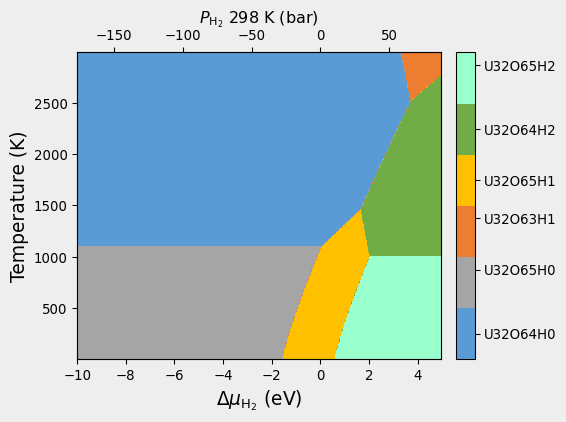

In [97]:
system,c = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z)
system.plot_mu_p(set_style="seaborn-dark-palette", colourmap="RdBu", output="O2_0_All_mvt")

P H$_2$ vs T at PO$_2$ = -1

In [98]:
deltaX = {'Range': [ -10, 5],  'Label': 'H_2'}
deltaY = {'Range': [ 1, 3000], 'Label': 'Temperature'}

z_energy=-9.883704
mu_z = -1
x_energy=-6.771542

In [99]:
exp_x = temperature_correction("H2.txt", deltaY)
exp_z = temperature_correction("O2.txt", deltaY)

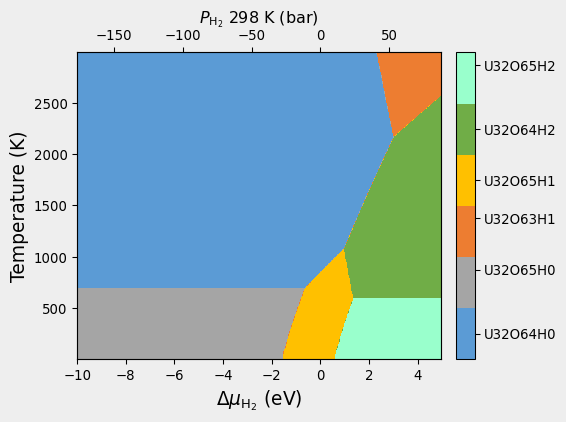

In [100]:
system,c = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z)
system.plot_mu_p(set_style="seaborn-dark-palette", colourmap="RdBu", output="O2_-1_All_mvt")

P H$_2$ vs T at PO$_2$ = 0 No Bulk

In [101]:
U32O64H0 =     {'Cation': 32, 'X': 0, 'Z': 0, 'Energy': 1000000,   'Label': 'U32O64H0'}
data = [U32O64H0, U32O64H1, U32O64H2, U32O63H0, U32O63H1,  U32O63H2, U32O65H0, U32O65H1, U32O65H2]

In [102]:
deltaX = {'Range': [ -10, 5],  'Label': 'H_2'}
deltaY = {'Range': [ 1, 3000], 'Label': 'Temperature'}

z_energy=-9.883704
mu_z = 0
x_energy=-6.771542

In [103]:
exp_x = temperature_correction("H2.txt", deltaY)
exp_z = temperature_correction("O2.txt", deltaY)

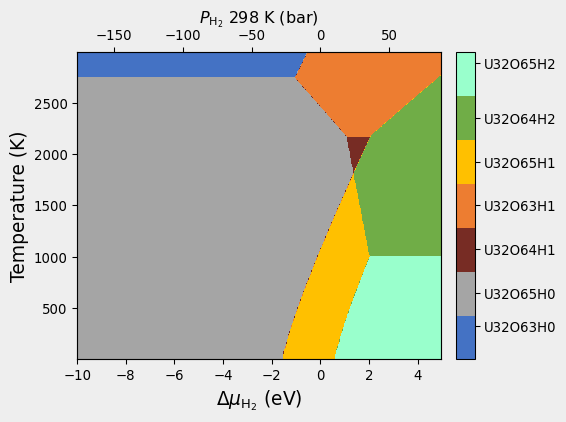

In [104]:
system,c = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z)
system.plot_mu_p(set_style="seaborn-dark-palette", colourmap="RdBu", output="O2_0_NoBulk_mvt")

P H$_2$ vs T at PO$_2$ = -1 No Bulk

In [105]:
deltaX = {'Range': [ -10, 5],  'Label': 'H_2'}
deltaY = {'Range': [ 1, 3000], 'Label': 'Temperature'}

z_energy=-9.883704
mu_z = -1
x_energy=-6.771542

In [106]:
exp_x = temperature_correction("H2.txt", deltaY)
exp_z = temperature_correction("O2.txt", deltaY)

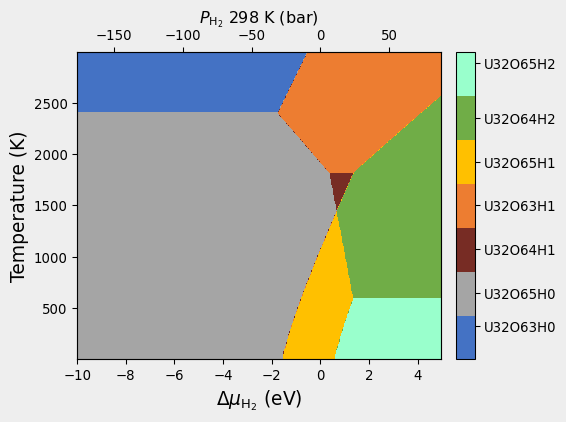

In [107]:
system,c = calculate(data, bulk, deltaX, deltaY, x_energy, z_energy, mu_z, exp_x, exp_z)
system.plot_mu_p(set_style="seaborn-dark-palette", colourmap="RdBu", output="O2_-1_NoBulk_mvt")